# Data Analysis

## 1. Loading the data

In [1]:
import re
from nltk import sent_tokenize

cg_sents = []
smg_sents = []

def remove_duplicate_punctuation(s): # sent_tokenize() gets confused when there's duplicate punctuation 
    return(re.sub(r'(\.|\?|!|;)\1+', r'\1 ', s))  # In a previous version of this I used r'\1' instead of r'\1 '. However it caused a problem for sentences like "this is great...I don't know what to do." It seems that some people do not use spacing with ellipses which caused sent_tokenize() to not identify a new sentence.
    
with open('./Data/cg_twitter.txt', 'r', encoding='utf-8') as in_file:
    text = remove_duplicate_punctuation(in_file.read())
    lines = [p for p in text.split('\n') if p] # sent_tokenize() doesn't consider a new line a new sentence so this is required.
    for line in lines:
        cg_sents += sent_tokenize(line)
    
with open('./Data/cg_fb.txt', 'r', encoding='utf-8') as in_file:
    text = remove_duplicate_punctuation(in_file.read())
    lines = [p for p in text.split('\n') if p]
    for line in lines:
        cg_sents += sent_tokenize(line)
    
with open('./Data/cg_other.txt', 'r', encoding='utf-8') as in_file:
    text = remove_duplicate_punctuation(in_file.read())
    lines = [p for p in text.split('\n') if p]
    for line in lines:
        cg_sents += sent_tokenize(line)

with open('./Data/smg_twitter.txt', 'r', encoding='utf-8') as in_file:
    text = remove_duplicate_punctuation(in_file.read())
    lines = [p for p in text.split('\n') if p]
    for line in lines:
        smg_sents += sent_tokenize(line)
    
with open('./Data/smg_fb.txt', 'r', encoding='utf-8') as in_file:
    text = remove_duplicate_punctuation(in_file.read())
    lines = [p for p in text.split('\n') if p]
    for line in lines:
        smg_sents += sent_tokenize(line)
    
with open('./Data/smg_other.txt', 'r', encoding='utf-8') as in_file:
    text = remove_duplicate_punctuation(in_file.read())
    lines = [p for p in text.split('\n') if p]
    for line in lines:
        smg_sents += sent_tokenize(line)

cg_sents[:3]

['Πρασινο αυκουι μες το πασχαλινο ποτήρι που έπιασε ο μιτσης #αισχος 🤣🤣🤣   @HARRIS_APOEL https://t.co/y9X7CmBEa5',
 '@HARRIS_APOEL @pirpoitis @vassrules Καμνουν ανακαινιση στα Περβολια φετος.',
 '@MUFCChristian Ελα συγγενη τζιαι εχουμε νεοτερα π το Νικολη.']

## 2. Cleaning the data

In [2]:
import unicodedata
from string import punctuation
from nltk.tokenize import WhitespaceTokenizer

punctuation += '΄’…“”–—―' # string.punctuation misses these.

def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def get_clean_sent_el(sentence):
    sentence = re.sub(r'^RT', '', sentence)
    sentence = re.sub(r'\&\w*;', '', sentence)
    sentence = re.sub(r'\@\w*', '', sentence)
    sentence = re.sub(r'\$\w*', '', sentence)
    sentence = re.sub(r'https?:\/\/.*\/\w*', '', sentence)
    sentence = ''.join(c for c in sentence if c <= '\uFFFF')
    sentence = strip_accents(sentence)
    sentence = re.sub(r'#\w*', '', sentence)
    sentence = sentence.lower()
    tokens = WhitespaceTokenizer().tokenize(sentence)
    new_tokens = []
    for token in tokens:
        if token == 'ο,τι' or token == 'ό,τι' or token == 'o,ti' or token == 'ó,ti':
            new_tokens.append(token.replace(' ', ''))
        else:
            token = re.sub(r'(?<=[.,!\?;\'΄’])(?=[^\s])', r' ', token) # If there is punctuation not followed by a space, we add it. I also added a space after apostrophes because I want something like σαγαπώ to not be considered as one word.
            new_token = token.translate(str.maketrans({key: None for key in punctuation}))
            if (new_token != ''): # This might happen if a user surrounds commas with spaces , like so. 
                new_tokens.append(new_token)
    sentence =' '.join(new_tokens)
    sentence = sentence.strip(' ') # performs lstrip() and rstrip()
    return sentence

cg_sents_clean = []
smg_sents_clean = []

for sent in cg_sents:
    cg_sents_clean.append(get_clean_sent_el(sent))
for sent in smg_sents:
    smg_sents_clean.append(get_clean_sent_el(sent))

# Remove empty strings left due to sentences ending up being only URLs then getting deleted on cleaning:
cg_sents_clean = list(filter(None, cg_sents_clean))
smg_sents_clean = list(filter(None, smg_sents_clean))
cg_sents_clean[:3]

['πρασινο αυκουι μες το πασχαλινο ποτηρι που επιασε ο μιτσης',
 'καμνουν ανακαινιση στα περβολια φετος',
 'ελα συγγενη τζιαι εχουμε νεοτερα π το νικολη']

## 3. Tokenization and setting up to use `nltk.text`

### 3.1 Tokenization

In [3]:
cg_sents_tokens = []
smg_sents_tokens = []

for sent in cg_sents_clean:
    cg_sents_tokens.append(WhitespaceTokenizer().tokenize(sent))
for sent in smg_sents_clean:
    smg_sents_tokens.append(WhitespaceTokenizer().tokenize(sent))
    
cg_sents_tokens[:3]

[['πρασινο',
  'αυκουι',
  'μες',
  'το',
  'πασχαλινο',
  'ποτηρι',
  'που',
  'επιασε',
  'ο',
  'μιτσης'],
 ['καμνουν', 'ανακαινιση', 'στα', 'περβολια', 'φετος'],
 ['ελα', 'συγγενη', 'τζιαι', 'εχουμε', 'νεοτερα', 'π', 'το', 'νικολη']]

### 3.2 Setting up to use `nltk.text`

#### 3.2.1 Words `Text` objects

In [4]:
from nltk.text import Text

cg_words_flat = [word for sent_tokens in cg_sents_tokens for word in sent_tokens]
smg_words_flat = [word for sent_tokens in smg_sents_tokens for word in sent_tokens]

cg_Text = Text(cg_words_flat)
smg_Text = Text(smg_words_flat)

cg_words_flat = [re.sub(r'ς', 'σ', word) for word in cg_words_flat] # The reason I replace ς with σ for char n-grams is because the Greek final sigma form is arbitrary. No other letter has a final form. When counting the number of sigmas I would like that to include the final forms as well. The σ_ bigram will represent the ς feature so it can be removed.
smg_words_flat = [re.sub(r'ς', 'σ', word) for word in smg_words_flat]

cg_Text

<Text: πρασινο αυκουι μες το πασχαλινο ποτηρι που επιασε...>

#### 3.2.2 Word n-grams

##### 3.2.2.1 Bigrams `Text` objects

In [5]:
from nltk import ngrams

cg_word_bigrams = []
smg_word_bigrams = []

for sent in cg_sents_tokens:
    cg_word_bigrams.append(list(ngrams(sent, 2)))
for sent in smg_sents_tokens:
    smg_word_bigrams.append(list(ngrams(sent, 2)))

print(cg_word_bigrams)    
    
cg_word_bigrams_flat_tuples = [bigram for bigram_list in cg_word_bigrams for bigram in bigram_list]
smg_word_bigrams_flat_tuples = [bigram for bigram_list in smg_word_bigrams for bigram in bigram_list]

cg_word_bigrams_flat = ['%s %s' % bigram_tuple for bigram_tuple in cg_word_bigrams_flat_tuples]
smg_word_bigrams_flat = ['%s %s' % bigram_tuple for bigram_tuple in smg_word_bigrams_flat_tuples]

cg_word_bigrams_Text = Text(cg_word_bigrams_flat)
smg_word_bigrams_Text = Text(smg_word_bigrams_flat)
cg_word_bigrams_Text

[[('πρασινο', 'αυκουι'), ('αυκουι', 'μες'), ('μες', 'το'), ('το', 'πασχαλινο'), ('πασχαλινο', 'ποτηρι'), ('ποτηρι', 'που'), ('που', 'επιασε'), ('επιασε', 'ο'), ('ο', 'μιτσης')], [('καμνουν', 'ανακαινιση'), ('ανακαινιση', 'στα'), ('στα', 'περβολια'), ('περβολια', 'φετος')], [('ελα', 'συγγενη'), ('συγγενη', 'τζιαι'), ('τζιαι', 'εχουμε'), ('εχουμε', 'νεοτερα'), ('νεοτερα', 'π'), ('π', 'το'), ('το', 'νικολη')], [('η', 'αληθκεια'), ('αληθκεια', 'με'), ('με', 'τους'), ('τους', 'τερματοφυλακες'), ('τερματοφυλακες', 'και'), ('και', 'οχι'), ('οχι', 'μονο'), ('μονο', 'εχουμε'), ('εχουμε', 'λιο'), ('λιο', 'θεμα')], [('μεχρι', 'και'), ('και', 'αυγουστη'), ('αυγουστη', 'και'), ('και', 'πανο'), ('πανο', 'κωνσταντινου'), ('κωνσταντινου', 'εφεραμε'), ('εφεραμε', 'ρε')], [('ωσπου', 'να'), ('να', 'φαεις'), ('φαεις', 'το'), ('το', 'κραμπι'), ('κραμπι', 'σου'), ('σου', 'εν'), ('εν', 'να'), ('να', 'τελειωσω'), ('τελειωσω', 'μεν'), ('μεν', 'φοασαι')], [('πρεπει', 'να'), ('να', 'εβρω'), ('εβρω', 'αλλη'), ('α

<Text: πρασινο αυκουι αυκουι μες μες το το πασχαλινο πασχαλινο ποτηρι ποτηρι που που επιασε επιασε ο...>

#### 3.2.3 Chars `Text` objects

In [6]:
cg_chars_flat = [char for word in cg_words_flat for char in word]
smg_chars_flat = [char for word in smg_words_flat for char in word]

cg_chars_Text = Text(cg_chars_flat)
smg_chars_Text = Text(smg_chars_flat)
cg_chars_Text

<Text: π ρ α σ ι ν ο α...>

#### 3.2.4 Character n-grams

##### 3.2.4.1 Bigrams `Text` objects

In [7]:
cg_char_bigrams = []
smg_char_bigrams = []

for word in cg_words_flat:
    cg_char_bigrams.append(list(ngrams(word, 2, pad_left=True, pad_right=True, left_pad_symbol='_', right_pad_symbol='_')))
for word in smg_words_flat:
    smg_char_bigrams.append(list(ngrams(word, 2, pad_left=True, pad_right=True, left_pad_symbol='_', right_pad_symbol='_'))) 

cg_char_bigrams_flat_tuples = [bigram for bigram_list in cg_char_bigrams for bigram in bigram_list]
smg_char_bigrams_flat_tuples = [bigram for bigram_list in smg_char_bigrams for bigram in bigram_list]

cg_char_bigrams_flat = ['%s%s' % bigram_tuple for bigram_tuple in cg_char_bigrams_flat_tuples]
smg_char_bigrams_flat = ['%s%s' % bigram_tuple for bigram_tuple in smg_char_bigrams_flat_tuples]

cg_char_bigrams_Text = Text(cg_char_bigrams_flat)
smg_char_bigrams_Text = Text(smg_char_bigrams_flat)
cg_char_bigrams_Text

<Text: _π πρ ρα ασ σι ιν νο ο_...>

##### 3.2.4.2 Trigrams `Text` objects

In [8]:
import warnings

cg_char_trigrams = []
smg_char_trigrams = []

with warnings.catch_warnings():
    warnings.filterwarnings('ignore',category=DeprecationWarning)
    for word in cg_words_flat:
        if len(word) > 1: # Trigram features for 1-letter words are useless and encoded by other features I use.
            cg_char_trigrams.append(list(ngrams(word, 3, pad_left=True, pad_right=True, left_pad_symbol='_', right_pad_symbol='_')))
    for word in smg_words_flat:
        if len(word) > 1:
            smg_char_trigrams.append(list(ngrams(word, 3, pad_left=True, pad_right=True, left_pad_symbol='_', right_pad_symbol='_')))

# Removing redundant trigrams:
cg_char_trigrams = [trigram_list[1:-1] for trigram_list in cg_char_trigrams]
smg_char_trigrams = [trigram_list[1:-1] for trigram_list in smg_char_trigrams]

cg_char_trigrams_flat_tuples = [trigram for trigram_list in cg_char_trigrams for trigram in trigram_list]
smg_char_trigrams_flat_tuples = [trigram for trigram_list in smg_char_trigrams for trigram in trigram_list]

cg_char_trigrams_flat = ['%s%s%s' % trigram_tuple for trigram_tuple in cg_char_trigrams_flat_tuples]
smg_char_trigrams_flat = ['%s%s%s' % trigram_tuple for trigram_tuple in smg_char_trigrams_flat_tuples]

cg_char_trigrams_Text = Text(cg_char_trigrams_flat)
smg_char_trigrams_Text = Text(smg_char_trigrams_flat)
cg_char_trigrams_Text

<Text: _πρ πρα ρασ ασι σιν ινο νο_ _αυ...>

## 4. Analysis

### 4.1. Corpus size

In [9]:
print('Number of CG sentences:', len(cg_sents_clean))
print('Number of SMG sentences:', len(smg_sents_clean))

Number of CG sentences: 565
Number of SMG sentences: 132


In [10]:
print('Number of words in CG data:', len(cg_words_flat))
print('Number of words in SMG data:', len(smg_words_flat))

Number of words in CG data: 6804
Number of words in SMG data: 1834


### 4.2 Most frequent words and characters

#### 4.2.1 Most frequent words

##### 4.2.1.1 CG

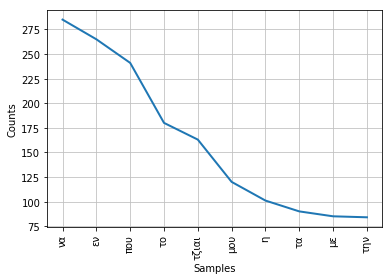

In [12]:
cg_Text.plot(10)

##### 4.2.1.2 SMG

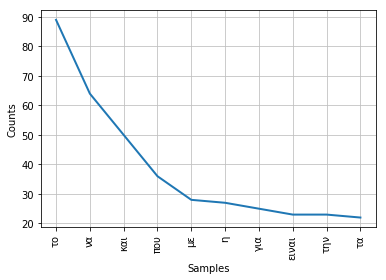

In [13]:
smg_Text.plot(10)

#### 4.2.2 Most frequent characters

##### 4.2.2.1 CG

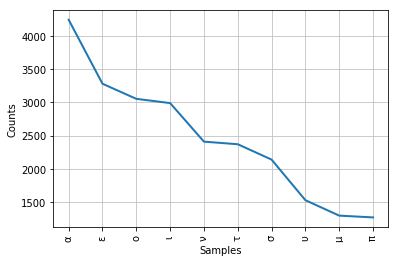

In [14]:
cg_chars_Text.plot(10)

##### 4.2.2.2 SMG

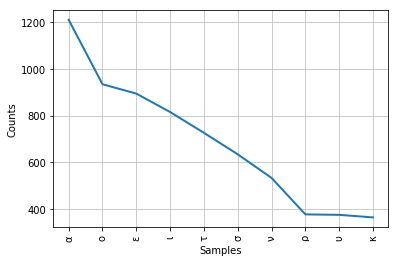

In [15]:
smg_chars_Text.plot(10)

NB: Recall that 'σ' in the most frequent character charts above includes instances of both 'σ' and 'ς'.

### 4.3 Most frequent word n-grams

#### 4.3.1 Bigrams

##### 4.3.1.1 CG

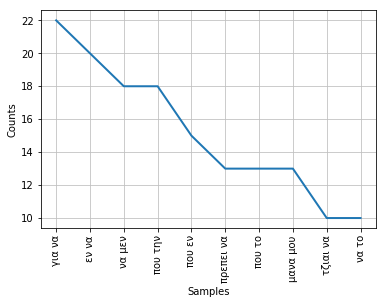

In [16]:
cg_word_bigrams_Text.plot(10)

##### 4.3.1.2 SMG

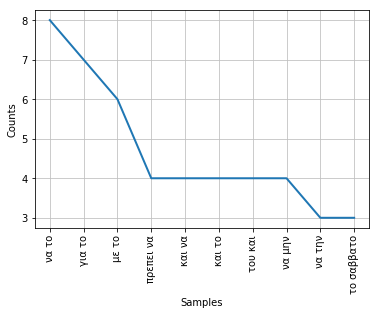

In [17]:
smg_word_bigrams_Text.plot(10)

### 4.4 Most frequent character n-grams

#### 4.4.1 Bigrams

##### 4.4.1.1 CG

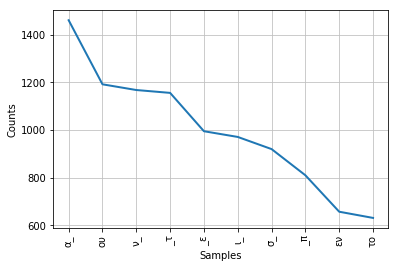

In [18]:
cg_char_bigrams_Text.plot(10)

##### 4.4.1.2 SMG

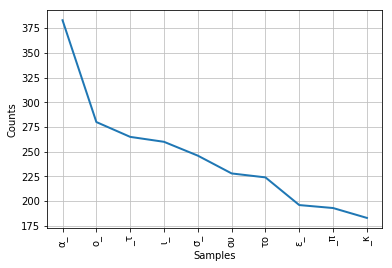

In [19]:
smg_char_bigrams_Text.plot(10)

#### 4.4.2 Trigrams

##### 4.4.2.1 CG

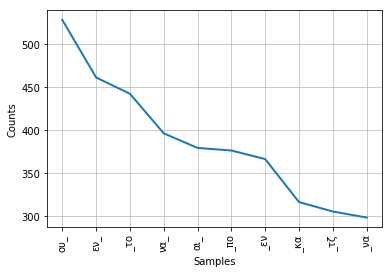

In [20]:
cg_char_trigrams_Text.plot(10)

##### 4.4.2.2 SMG

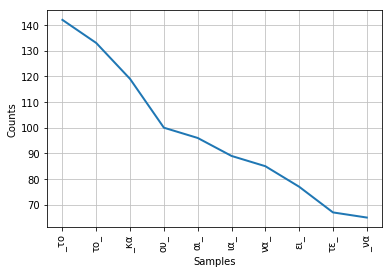

In [21]:
smg_char_trigrams_Text.plot(10)